## Code to perform binary classification of patients with pre-diabetes/lifestyle controlled diabetes and patients with diabetes needing medication.
### We first make sure that the dataframe for HbA1c contains only patients who also have CGM data so that the datasets are consistent across experiments


In [20]:
import pandas as pd

In [21]:
df_clinical = pd.read_csv(r"HbA1c_all_patients.csv")
df_clinical["HbA1c (%)"]

0       5.7
1       5.5
2       5.9
3       5.8
4       5.6
       ... 
1011    6.1
1012    6.9
1013    7.4
1014    5.5
1015    5.7
Name: HbA1c (%), Length: 1016, dtype: float64

In [22]:
# For consistency only pick patients who have CGM records
pkl_glucose_info = "dataframe_with_glucose_info.pkl"
dataframe_with_glucose_values_diabetes = pd.read_pickle(pkl_glucose_info)
df = dataframe_with_glucose_values_diabetes
print(df.shape)
print(df.columns)
# Pick only patients corresponding to prediabetes/life-style controlled diabetes and diabetes with medications.
df = df[df['study_group_id'].isin([1,2])]
df['study_group_id'] = df['study_group_id'] - 1
print(df.shape)
df_clinical.rename(columns={'participant_id':'patient_ids'},inplace=True)
#df_clinical = df_clinical[df_clinical['patient_ids'].isin(df['patient_ids'])]
df_clinical = df_clinical.merge(df[['patient_ids','study_group_id']], on="patient_ids")
print(df_clinical.shape)

df_clinical.drop(columns=['Unnamed: 0'], inplace=True)
print(df_clinical.columns)

(1011, 10)
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id'],
      dtype='object')
(538, 10)
(511, 8)
Index(['patient_ids', 'age', 'study_group', 'recommended_split',
       'clinical_site', 'HbA1c (%)', 'study_group_id'],
      dtype='object')


C:\Users\preet\AppData\Local\Temp\ipykernel_29888\1389120274.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['study_group_id'] = df['study_group_id'] - 1


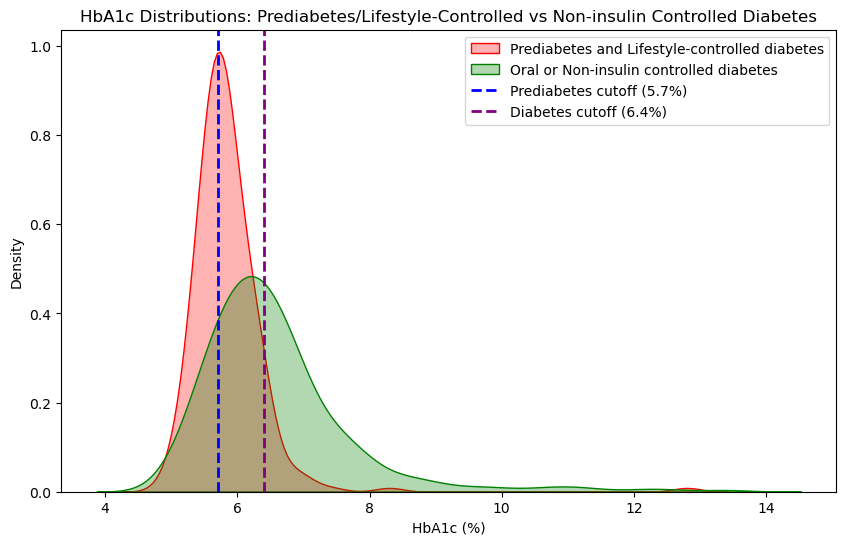

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop HbA1c values < 1
study1 = df_clinical.loc[
    (df_clinical["study_group"] == "pre_diabetes_lifestyle_controlled") &
    (df_clinical["HbA1c (%)"] >= 1),
    "HbA1c (%)"
]

study2 = df_clinical.loc[
    (df_clinical["study_group"] == "oral_medication_and_or_non_insulin_injectable_medication_controlled") &
    (df_clinical["HbA1c (%)"] >= 1),
    "HbA1c (%)"
]

# Plot overlapping filled distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(study1, color="red", label="Prediabetes and Lifestyle-controlled diabetes", fill=True, alpha=0.3)
sns.kdeplot(study2, color="green", label="Oral or Non-insulin controlled diabetes", fill=True, alpha=0.3)

# Add vertical lines at diagnostic cutoffs
plt.axvline(5.7, color="blue", linestyle="--", linewidth=2, label="Prediabetes cutoff (5.7%)")
plt.axvline(6.4, color="purple", linestyle="--", linewidth=2, label="Diabetes cutoff (6.4%)")

plt.xlabel("HbA1c (%)")
plt.ylabel("Density")
plt.title("HbA1c Distributions: Prediabetes/Lifestyle-Controlled vs Non-insulin Controlled Diabetes")
plt.legend()
plt.show()


In [24]:
df2= pd.read_csv("C:\\Users\\preet\\Documents\\ai-readi-notebooks\\main\\metadata_diseases\\conditions_all.csv")
df2.rename(columns={'participant_id':'patient_ids'},inplace=True)
df2 = df2[['patient_ids','mhterm_dm2, Type II Diabetes']] #, 'mhterm_predm, Pre-diabetes']]
print(df2.columns)
df_clinical = df_clinical.merge(df2, on="patient_ids")
df_all2 = df_clinical[['HbA1c (%)','recommended_split','study_group_id','mhterm_dm2, Type II Diabetes']]
print(df_all2.columns)

Index(['patient_ids', 'mhterm_dm2, Type II Diabetes'], dtype='object')
Index(['HbA1c (%)', 'recommended_split', 'study_group_id',
       'mhterm_dm2, Type II Diabetes'],
      dtype='object')


Feature columns: ['HbA1c (%)']
Accuracy: 0.6621621621621622
Confusion Matrix:
 [[21 14]
 [11 28]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63        35
           1       0.67      0.72      0.69        39

    accuracy                           0.66        74
   macro avg       0.66      0.66      0.66        74
weighted avg       0.66      0.66      0.66        74

ROC AUC Score: 0.7311
AUPRC Score: 0.7576


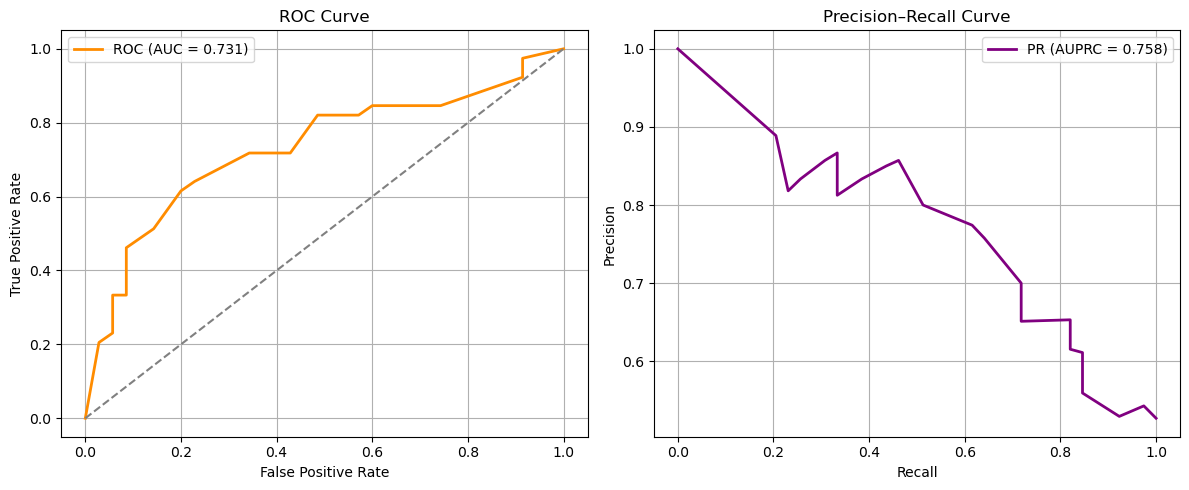

Accuracy: 0.6621621621621622
Balanced Accuracy: 0.658974358974359

Confusion Matrix:
 [[21 14]
 [11 28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.63        35
           1       0.67      0.72      0.69        39

    accuracy                           0.66        74
   macro avg       0.66      0.66      0.66        74
weighted avg       0.66      0.66      0.66        74

F1 score 0.691358024691358
ROC AUC Score: 0.7311
AUPRC Score: 0.7576


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np
from cgm_dataset_transform import print_results

# ----- Split Data -----
df_train = df_all2[df_all2['recommended_split'] == 'train']
df_val   = df_all2[df_all2['recommended_split'] == 'val']
df_test  = df_all2[df_all2['recommended_split'] == 'test']

train_df = df_train.reset_index(drop=True)
val_df   = df_val.reset_index(drop=True)
test_df  = df_test.reset_index(drop=True)

col = 'study_group_id'
cols_to_drop = ['study_group_id', 'mhterm_dm2, Type II Diabetes', 'recommended_split']

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df[col]
X_val   = val_df.drop(columns=cols_to_drop)
y_val   = val_df[col]
X_test  = test_df.drop(columns=cols_to_drop)
y_test  = test_df[col]

print("Feature columns:", X_train.columns.tolist())

# ----- Train Random Forest -----
rf = RandomForestClassifier(n_estimators=128, n_jobs=1)
rf.fit(X_train, y_train)

# ----- Predict -----
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for positive class

# ----- Evaluate -----
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# ----- ROC AUC -----
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ----- AUPRC -----
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
auprc = average_precision_score(y_test, y_prob)
print(f"AUPRC Score: {auprc:.4f}")

# ----- Plot ROC and PR curves side by side -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', linewidth=2,
             label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True)

# Precision–Recall Curve
axes[1].plot(recall, precision, color='purple', linewidth=2,
             label=f'PR (AUPRC = {auprc:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision–Recall Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
results_pca_rf = print_results(y_test, y_prob)